# Aula de K-Nearest Neighbors (KNN)

Olá, cientista de Dados!

Seja bem-vindo(a) à nossa aula sobre o **K-Nearest Neighbors (KNN)**, ou K-Vizinhos Mais Próximos.

### Uma Analogia Simples

Imagine que você se mudou para um bairro novo e quer decidir se vai comprar um carro elétrico ou um a combustão. Uma abordagem seria olhar para os seus **5 vizinhos mais próximos (K=5)** e ver o que a maioria deles tem. Se 3 têm carros elétricos e 2 têm carros a combustão, você provavelmente se inclinaria a comprar um elétrico.

O KNN funciona exatamente assim! Ele é um algoritmo "preguiçoso" (lazy learner) porque não aprende uma "fórmula" complexa, mas sim memoriza todos os dados de treino e, para classificar um novo ponto, ele olha para a classe da maioria dos seus vizinhos mais próximos.

Simples, não é? Agora, vamos ver os detalhes por trás dessa ideia.

<img src='knn.png'/>


### Os Conceitos Fundamentais (Teoria Primeiro!)

Antes de pularmos para o código, vamos entender as três peças-chave do quebra-cabeça do KNN.

#### 1.1 Medindo a "Proximidade": A Distância Euclidiana

Para encontrar os "vizinhos mais próximos", precisamos de uma forma de medir a distância entre dois pontos. A mais comum é a **Distância Euclidiana**.

A fórmula parece complicada, mas a ideia é a mesma do Teorema de Pitágoras. Para dois pontos, `p` e `q`, em um espaço com `n` dimensões (ou `n` características), a distância é:

$$d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \dots + (p_n - q_n)^2}$$

**Exemplo "Mão na Massa" (Matemática):**
Vamos prever se um novo cliente (ponto `p`) vai comprar um produto com base na sua idade e salário.

-   **Novo Cliente (p):** Idade = 42, Salário = 50.000
-   **Vizinho 1 (q1):** Idade = 38, Salário = 60.000
-   **Vizinho 2 (q2):** Idade = 25, Salário = 45.000

Distância para o Vizinho 1:
$d(p, q1) = \sqrt{(42 - 38)^2 + (50000 - 60000)^2} = \sqrt{(4)^2 + (-10000)^2} = \sqrt{16 + 100.000.000} \approx 10.000$

Distância para o Vizinho 2:
$d(p, q2) = \sqrt{(42 - 25)^2 + (50000 - 45000)^2} = \sqrt{(17)^2 + (5000)^2} = \sqrt{289 + 25.000.000} \approx 5.000$

**Conclusão:** O **Vizinho 2** está "mais próximo" do nosso novo cliente.


#### 1.2 Distância Manhattan (L1)

$$
d(\vec{x}, \vec{y}) = \sum_{i=1}^{n} |x_i - y_i|
$$

Soma das diferenças absolutas. Também chamada de **distância do táxi** (movimento em grade, como ruas de uma cidade).

<img src='dist_manhattan.png'/>





#### 2. A Importância de Normalizar os Dados (Feature Scaling)

Percebeu um problema no nosso cálculo? O salário, por ter uma escala muito maior (milhares), dominou completamente a distância! A diferença de idade quase não fez cócegas no resultado.

Isso é um grande problema para o KNN. Se não colocarmos todas as nossas características (features) na mesma escala, o algoritmo dará uma importância desproporcional para as features com valores maiores.

Por isso, a **normalização/padronização dos dados é uma etapa OBRIGATÓRIA** antes de usar o KNN.

#### 3. Como Escolher o Melhor Valor de "K"?

A escolha do `K` (o número de vizinhos) é crucial e afeta diretamente o nosso modelo.

-   **K pequeno (ex: K=1):** O modelo se torna muito sensível a ruídos e pontos anômalos. Ele pode "superajustar" (overfitting) aos dados de treino, criando uma fronteira de decisão muito complexa.
-   **K grande (ex: K=40):** O modelo se torna muito "suave" e pode ignorar padrões locais importantes. Ele pode "subajustar" (underfitting), sendo simples demais para capturar a complexidade dos dados.

Isso é o famoso **trade-off entre viés e variância**. Como encontrar um bom equilíbrio? Usaremos uma técnica chamada **Método do Cotovelo (Elbow Method)**, que vamos implementar na prática! A ideia é testar vários valores de K e escolher aquele onde a taxa de erro para de diminuir drasticamente.

### Aplicação Prática: Previsão de Compra

Agora que a teoria está clara, vamos aplicar o KNN para prever se um cliente irá comprar um produto com base em sua idade e salário estimado.

#### Passo 1: Preparação do Ambiente e Carregamento dos Dados

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Carregando o conjunto de dados
df = pd.read_csv('Social_Network_Ads.csv')

# Exibindo as 5 primeiras linhas
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


#### Passo 2: Análise Exploratória e Limpeza

Vamos entender e preparar nossos dados.

In [11]:
# A coluna 'User ID' é um identificador único, não ajuda na previsão.
# A coluna 'Gender' poderia ser usada, mas para simplificar este primeiro exercício, vamos removê-la.
df = df.drop(columns=['User ID', 'Gender'])

# Vamos verificar as informações do nosso dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


Os dados estão limpos e sem valores nulos. Vamos visualizar a relação entre idade, salário e a decisão de compra.

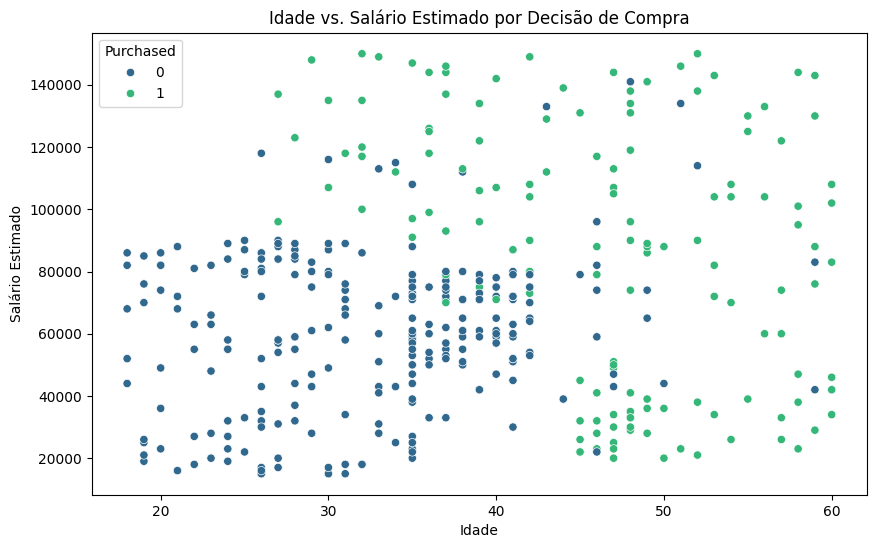

In [12]:
# Criando um gráfico de dispersão para visualizar os dados
# Eixo X: Idade, Eixo Y: Salário, Cor: Comprou (0=Não, 1=Sim)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='EstimatedSalary', hue='Purchased', palette='viridis')
plt.title('Idade vs. Salário Estimado por Decisão de Compra')
plt.xlabel('Idade')
plt.ylabel('Salário Estimado')
plt.show()

O gráfico nos dá uma boa intuição: parece haver um padrão onde pessoas mais velhas e com salários mais altos (grupo verde/azul no canto superior direito) tendem a comprar mais. O KNN tentará aprender essa fronteira de decisão.

#### Passo 3: Pré-Processamento dos Dados

In [13]:
# Separando as features (X) da variável alvo (y)
X = df.drop(columns='Purchased',axis=1)
y = df['Purchased']

In [14]:
# Divisão em dados de Treino e Teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [15]:
# Normalização/Padronização dos Dados (Passo Obrigatório para o KNN!)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# ATENÇÃO: Ajustamos o scaler APENAS nos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# E usamos o mesmo scaler para transformar os dados de teste
X_test_scaled = scaler.transform(X_test)

#### Passo 4: Encontrando o Melhor Valor de K (Método do Cotovelo)

Vamos testar o modelo com diferentes valores de K (de 1 a 40) e plotar a taxa de erro para cada um. O "cotovelo" do gráfico nos indicará um bom valor para K.

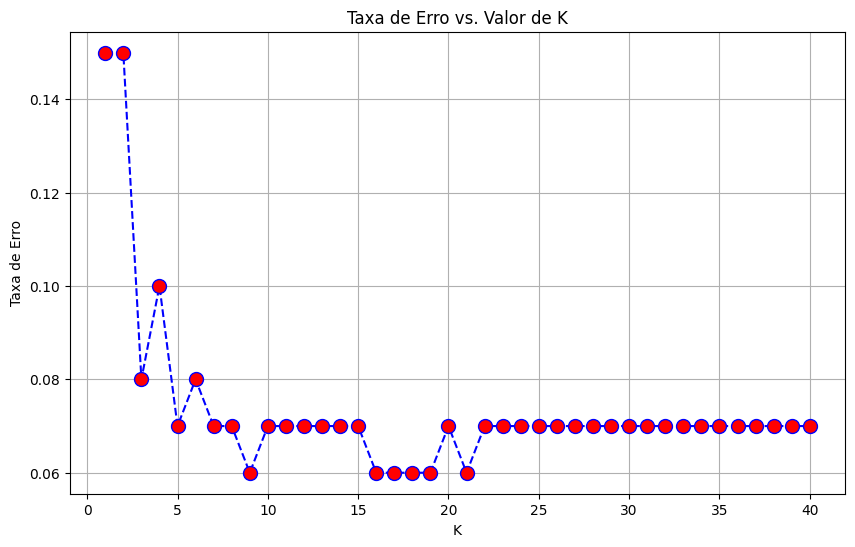

In [17]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

# Loop para testar K de 1 a 40
for i in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # Calcula a média dos erros (onde a previsão foi diferente do real)
    error_rate.append(np.mean(pred_i != y_test))

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Taxa de Erro vs. Valor de K')
plt.xlabel('K')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()

Analisando o gráfico, vemos que a taxa de erro é alta para valores de K muito baixos e se estabiliza a partir de K=9, atingindo um ponto ótimo por volta de K=11. Vamos escolher **K=11** para o nosso modelo final, pois é um bom ponto de equilíbrio antes que a taxa de erro comece a subir novamente.

#### Passo 5: Treinamento e Avaliação do Modelo Final

In [18]:
# Criando e treinando o modelo final com K=11
knn_final = KNeighborsClassifier(n_neighbors=11)
knn_final.fit(X_train_scaled, y_train)

# Fazendo as previsões
y_pred = knn_final.predict(X_test_scaled)

--- Matriz de Confusão ---


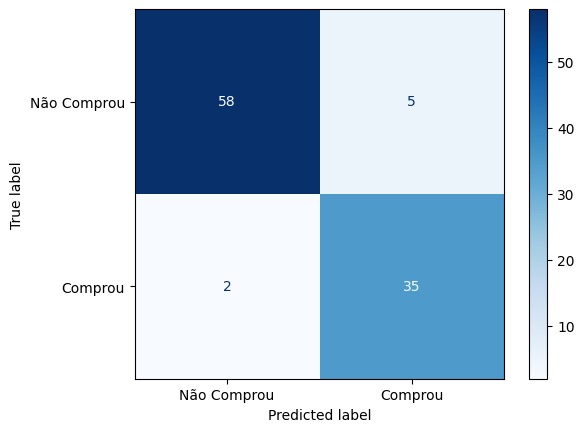


--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        63
           1       0.88      0.95      0.91        37

    accuracy                           0.93       100
   macro avg       0.92      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [19]:
# Avaliando o modelo com a Matriz de Confusão e o Relatório de Classificação
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print("--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Comprou', 'Comprou'])
disp.plot(cmap='Blues')
plt.show()


print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

### Resumo: Prós e Contras do KNN

Para finalizar, é sempre bom ter em mente as forças e fraquezas de cada algoritmo.

#### Vantagens 👍
* **Simples e Intuitivo:** Fácil de entender e implementar.
* **Não requer treinamento:** O algoritmo é "preguiçoso", ele apenas armazena os dados. A computação ocorre no momento da previsão.
* **Flexível:** Pode ser usado tanto para classificação quanto para regressão.
* **Não-linear:** Consegue aprender fronteiras de decisão complexas.

#### Desvantagens 👎
* **Custo Computacional:** Fica muito lento e caro (em termos de memória e processamento) em conjuntos de dados muito grandes, pois precisa calcular a distância para todos os pontos a cada nova previsão.
* **Sensível a Features Irrelevantes:** Se tivermos muitas colunas que não ajudam na previsão, elas podem "poluir" o cálculo da distância e piorar o resultado.
* **Requer Normalização:** Como vimos, é obrigatório colocar os dados na mesma escala.
* **Maldição da Dimensionalidade:** O conceito de "distância" se torna menos útil em espaços com muitas dimensões (muitas features).

Parabéns por concluir esta aula! O KNN é uma excelente ferramenta para se ter no seu arsenal.